In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib

import os
import numpy as np
import sys
sys.path.append("..")
from scripts.utils import get_path, get_noise_in_estimator
from vis_utils.loaders import load_dataset, zebra_color_to_label, zebra_label_to_color
from vis_utils.plot import add_scale, plot_scatter
import pickle


In [ ]:
root_path = get_path("data")
fig_path = get_path("figures")

In [ ]:
# parameters for all methods
a = 1.0
b = 1.0
seed = 0
seeds = [0, 1, 2]
n_noise = 5

k = 15

In [ ]:
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [ ]:
dataset = "zebrafish"

x, y, sknn_graph, pca2 = load_dataset(root_path, dataset, k)
print(x.shape)

In [ ]:
key = "unused"
if "unused" in zebra_label_to_color:
    val = zebra_label_to_color.pop(key)
    zebra_color_to_label.pop(val)


In [ ]:
nbs_noise_in_estimator = get_noise_in_estimator(len(x), 5, dataset)
sorted_idx = np.argsort(nbs_noise_in_estimator)
nbs_noise_in_estimator = nbs_noise_in_estimator[sorted_idx]

In [ ]:
# non-exaggerated phase
parametric = False
log_embds = True
log_norms = True
log_kl = True
optimizer = "sgd"
n_epochs = 500
loss_mode = "neg_sample"
n_noise = 5
batch_size = 1024
rescale = 1.0
anneal_lr = True
momentum=0.0
lr_min_factor=0.0
clamp_low = 1e-10
on_gpu = True


embedders = []
for s in seeds:
    embedders_by_seed = []
    for noise_in_estimator in nbs_noise_in_estimator:
        file_name = os.path.join(root_path,
                                 dataset,
                                 f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_EE_bs_{batch_size}"
                                 f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{s}.pkl"
                                 )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    embedders.append(embedders_by_seed)
    print(f"Done with seed {s}")

In [ ]:
# show all embeddings for seed 0
n_rows = 5
n_cols = 5
plt.rcParams['font.size'] = 10

fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,20))
n_exp = len(embedders[0])
for i in range(n_exp):
    embd = embedders[0][i].callback.embds[-1]
    cax = ax[int(i / n_cols), i % n_cols]

    cax = plot_scatter(cax,
                       embd,
                       y,
                       r"$c=${:.2e}".format(nbs_noise_in_estimator[i])
                       + "\n" +r"$\bar{Z}=$"+"{:.2e}".format(nbs_noise_in_estimator[i] / (n_noise / len(x) / (len(x)-1))))


In [ ]:
# save points on the spectrum for paper

indices_to_save = [0,
                   np.where(sorted_idx == 0)[0][0],
                   np.where(sorted_idx == 1)[0][0],
                   15,
                   20]
titles = ["cne_neg_zebra_EE_low_Z.png",
          "cne_neg_zebra_EE_Z_tsne.png",
          "cne_neg_zebra_EE_Z_ncvis.png",
          "cne_neg_zebra_EE_Z_umap.png",
          "cne_neg_zebra_EE_high_Z.png"
          ]
for i, ind in enumerate(indices_to_save):
    plt.figure(figsize=(5,5))
    plot_scatter(plt.gca(), embedders[0][ind].callback.embds[-1], y)
    plt.savefig(os.path.join(fig_path,
                             titles[i]),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)
    plt.close()

In [ ]:
# compute final norms
final_norms = np.array([[embedders[i][j].callback.norms[-1][0] for j in range(len(nbs_noise_in_estimator))]
                        for i in range(len(seeds))])
final_norms_mean = final_norms.mean(0)
final_norms_std = final_norms.std(0)

# transform entry on estimator to Z_bar
Z_bars = nbs_noise_in_estimator * len(x) * (len(x) - 1) / 5

In [ ]:
# maximal relative standard deviation
(final_norms_std / final_norms_mean ).max()

In [ ]:
# panel on the partition function
fontsize = 15
plt.figure(figsize=(2, 2))
plt.rcParams['font.size'] = fontsize
start = 0
plt.plot(Z_bars[start:], final_norms_mean[start:], label=r"$\sum_{ij} q_\theta(ij)$", linewidth=1)
plt.fill_between(Z_bars[start:],
                 final_norms_mean[start:] - final_norms_std[start:],
                 final_norms_mean[start:] + final_norms_std[start:])

plt.scatter(Z_bars[indices_to_save], final_norms_mean[indices_to_save], marker="X", s=10, c="k", zorder=5)


panel_names = ["(a)", "(b)", "(c)", "(d)", "(e)"]
for i, ind in enumerate(indices_to_save):
    if i in [1, 3]:
        plt.text(0.7*Z_bars[ind], 0.1*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    elif i == 4:
        plt.text(0.3*Z_bars[ind], 0.1*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})

    elif i == 0:
        plt.text(0.6*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    else:
        plt.text(0.2*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xscale("log")
plt.yscale("log")
plt.gca().set_aspect("equal")

plt.xticks([1e4, 1e6, 1e8, 1e10], fontsize=fontsize)
plt.yticks([1e6, 1e8], fontsize=fontsize)

plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.gca().xaxis.set_label_coords(0.95, 0.25)
plt.savefig(os.path.join(fig_path,
                         f"cne_neg_zebra_EE_Z_spectrum.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

In [ ]:
# spectrum axis
csfont = {'fontsize': 12}

plt.figure(figsize=(10,1))
ax = plt.gca()

plt.scatter(Z_bars[indices_to_save], np.zeros(len(indices_to_save)), s=20, c="k")
plt.xscale("log")

# dummy points, somehow necessary to get extension in y direction
plt.scatter(1e5, 0.1, c="w")
plt.scatter(1e5, -0.4, c="w")

# intersection
ax.spines['left'].set_position(('data', 1e4))
ax.spines['bottom'].set_position(('data', 0))

# visibility of axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_ticks([])

#arrow tip
plt.plot(1, 0, ">k", markersize=4, transform=plt.gca().get_yaxis_transform(), clip_on=False)

# xlabel
plt.xlabel(r"$\bar{Z}$", fontsize=15)
ax.xaxis.set_label_coords(1.0, 0.55)
ax.spines["bottom"].set_linewidth(0.25)

ax.set_xticks([1e5, 1e6, 1e7, 1e8, 1e9, 1e10])
ax.xaxis.set_tick_params(width=0.25)
plt.xticks( **csfont)
plt.minorticks_off()

plt.savefig(os.path.join(fig_path,
                         f"zebra_spectrum_arrow.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

In [ ]:
num_labels = np.zeros_like(y, dtype="int")
for i, label in enumerate(zebra_color_to_label.values()):
    num_labels[y==zebra_label_to_color[label]] = i

In [ ]:
zebra_color_to_nice_label = {key: val[:-3]+" "+val[-3:] for key, val in zebra_color_to_label.items()}
print(zebra_color_to_nice_label)

In [ ]:
# get legend
plt.figure(figsize=(8,8))
scatter = plt.scatter(*(embedders[0][10].callback.embds[-1] @ [[-1,0], [0, 1]]).T,
                      s=1.0,
                      c=num_labels,
                      cmap=matplotlib.colors.ListedColormap(zebra_color_to_label.keys())
                      )

leg = plt.gca().legend(handles=scatter.legend_elements(num=[k for k in range(len(zebra_color_to_label.keys()))])[0],
                       labels=zebra_color_to_nice_label.values(),
                       bbox_to_anchor=(1.05, 1.0),
                       loc="upper left",
                       fontsize=12,
                       ncol=1,
                       handletextpad=0.2,
                       frameon=False)
# get figure with legend only
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(fig_path,"zebra_leg.png"), dpi=200, bbox_inches=bbox, pad_inches=0)

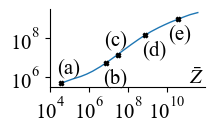

In [34]:
# panel on the partition function
fontsize = 15
plt.figure(figsize=(2, 2))
plt.rcParams['font.size'] = fontsize
start = 0
plt.plot(Z_bars[start:], final_norms_mean[start:], label=r"$\sum_{ij} q_\theta(ij)$", linewidth=1)
plt.fill_between(Z_bars[start:],
                 final_norms_mean[start:] - final_norms_std[start:],
                 final_norms_mean[start:] + final_norms_std[start:])

plt.scatter(Z_bars[indices_to_save], final_norms_mean[indices_to_save], marker="X", s=10, c="k", zorder=5)


panel_names = ["(a)", "(b)", "(c)", "(d)", "(e)"]
for i, ind in enumerate(indices_to_save):
    if i in [1, 3]:
        plt.text(0.7*Z_bars[ind], 0.1*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    elif i == 4:
        plt.text(0.3*Z_bars[ind], 0.1*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})

    elif i == 0:
        plt.text(0.6*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})
    else:
        plt.text(0.2*Z_bars[ind],3.5*final_norms_mean[ind], s=panel_names[i], fontdict={"size":fontsize})

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xscale("log")
plt.yscale("log")
plt.gca().set_aspect("equal")

plt.xticks([1e4, 1e6, 1e8, 1e10], fontsize=fontsize)
plt.yticks([1e6, 1e8], fontsize=fontsize)

plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.gca().xaxis.set_label_coords(0.95, 0.25)
plt.savefig(os.path.join(fig_path,
                         f"cne_neg_zebra_EE_Z_spectrum.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

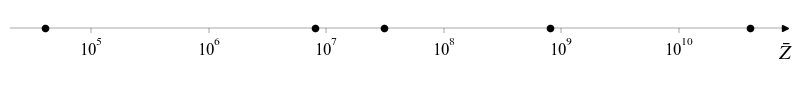

In [36]:
# spectrum axis
csfont = {'fontsize': 12}

plt.figure(figsize=(10,1))
ax = plt.gca()

plt.scatter(Z_bars[indices_to_save], np.zeros(len(indices_to_save)), s=20, c="k")
plt.xscale("log")

# dummy points, somehow necessary to get extension in y direction
plt.scatter(1e5, 0.1, c="w")
plt.scatter(1e5, -0.4, c="w")

# intersection
ax.spines['left'].set_position(('data', 1e4))
ax.spines['bottom'].set_position(('data', 0))

# visibility of axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_ticks([])

#arrow tip
plt.plot(1, 0, ">k", markersize=4, transform=plt.gca().get_yaxis_transform(), clip_on=False)

# xlabel
plt.xlabel(r"$\bar{Z}$", fontsize=15)
ax.xaxis.set_label_coords(1.0, 0.55)
ax.spines["bottom"].set_linewidth(0.25)

ax.set_xticks([1e5, 1e6, 1e7, 1e8, 1e9, 1e10])
ax.xaxis.set_tick_params(width=0.25)
plt.xticks( **csfont)
plt.minorticks_off()

plt.savefig(os.path.join(fig_path,
                         f"zebra_spectrum_arrow.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)

In [9]:
num_labels = np.zeros_like(y, dtype="int")
for i, label in enumerate(zebra_color_to_label.values()):
    num_labels[y==zebra_label_to_color[label]] = i

In [10]:
zebra_color_to_nice_label = {key: val[:-3]+" "+val[-3:] for key, val in zebra_color_to_label.items()}
print(zebra_color_to_nice_label)

{'navy': '4 hpf', 'royalblue': '6 hpf', 'skyblue': '8 hpf', 'lightgreen': '10 hpf', 'gold': '14 hpf', 'tomato': '18 hpf', 'firebrick': '24 hpf'}


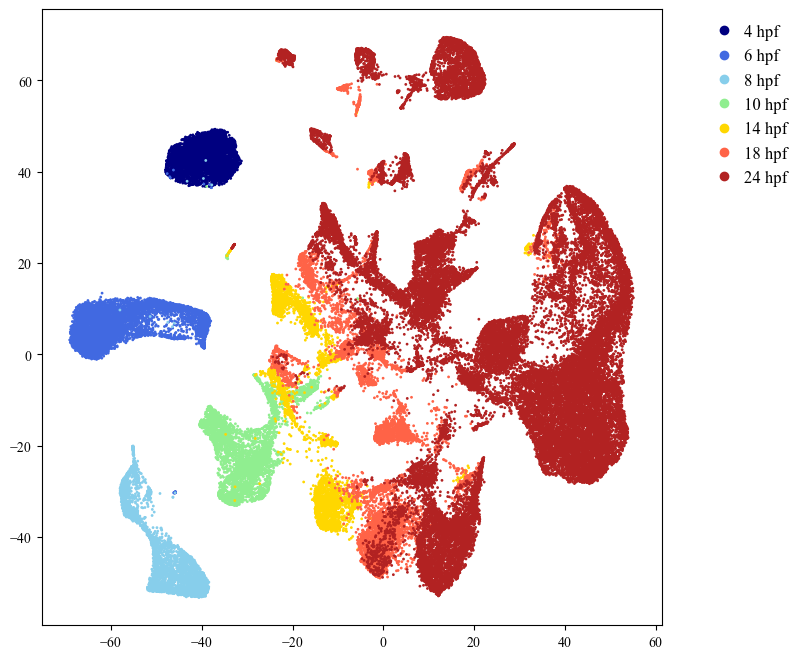

In [11]:
# get legend
plt.figure(figsize=(8,8))
scatter = plt.scatter(*(embedders[0][10].callback.embds[-1] @ [[-1,0], [0, 1]]).T,
                      s=1.0,
                      c=num_labels,
                      cmap=matplotlib.colors.ListedColormap(zebra_color_to_label.keys())
                      )

leg = plt.gca().legend(handles=scatter.legend_elements(num=[k for k in range(len(zebra_color_to_label.keys()))])[0],
                       labels=zebra_color_to_nice_label.values(),
                       bbox_to_anchor=(1.05, 1.0),
                       loc="upper left",
                       fontsize=12,
                       ncol=1,
                       handletextpad=0.2,
                       frameon=False)
# get figure with legend only
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(fig_path,"zebra_leg.png"), dpi=200, bbox_inches=bbox, pad_inches=0)